In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression

In [2]:
np.random.seed(1)

# Ingest data

In [3]:
p = pd.read_csv('../data/players.csv').set_index('id')  # players
p.head()

,first_name,second_name,now_cost,name,short_name,position
id,,,,,,
270,David,de Gea,52,Man Utd,MUN,GKP
280,Dean,Henderson,47,Man Utd,MUN,GKP
509,Tom,Heaton,39,Man Utd,MUN,GKP
183,Francisco,Casilla Cortés,45,Leeds,LEE,GKP
199,Illan,Meslier,48,Leeds,LEE,GKP


In [4]:
pf = os.listdir('../data/')
mask = pd.Series([f'p_{i}.csv' in pf for i in p.index], index=p.index)  # check player_history exists
p = p[mask]  # only picking players with data to analyse
ph = {i: pd.read_csv(f'../data/p_{i}.csv') for i in p.index}  # player_history, id is key to dict

# How strongly do minutes and points correlate?

In [5]:
_p = None
for i, df in ph.items():
    df['season_number'] = np.arange(df.shape[0]) + 1
    if _p is None:
        _p = df.assign(id=i)
    else:
        _p = _p.append(df.assign(id=i), ignore_index=True)
_p['position']  = _p['id'].apply(lambda x: p.loc[x, 'position'])

In [6]:
_p.head()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,saves,bonus,bps,influence,creativity,threat,ict_index,season_number,id,position
0,2011/12,51940,65,62,134,2610,0,0,13,29,...,111,1,0,0.0,0.0,0.0,0.0,1,270,GKP
1,2012/13,51940,60,58,114,2520,0,0,11,26,...,89,1,0,0.0,0.0,0.0,0.0,2,270,GKP
2,2013/14,51940,60,59,128,3330,0,0,12,43,...,99,0,158,0.0,0.0,0.0,0.0,3,270,GKP
3,2014/15,51940,55,58,138,3313,0,0,11,36,...,93,3,558,0.0,0.0,0.0,0.0,4,270,GKP
4,2015/16,51940,55,59,142,3060,0,0,15,33,...,82,8,613,0.0,0.0,0.0,0.0,5,270,GKP


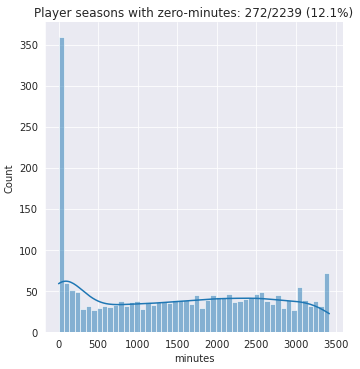

In [7]:
p_0mins = (_p['minutes'] == 0).sum()
with sns.axes_style('darkgrid'):
    sns.displot(_p['minutes'], bins=50, kde=True)
    plt.title(
        f'Player seasons with zero-minutes: {p_0mins}/{_p.shape[0]} ({100*p_0mins/_p.shape[0]:.1f}%)'
    )

In [8]:
_p = _p[_p['minutes']> 0]  # removing 0 minute seasons for now

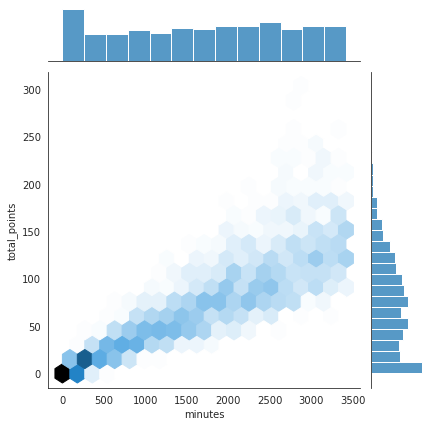

In [9]:
with sns.axes_style('white'):
    sns.jointplot(x='minutes', y='total_points', data=_p, kind='hex')

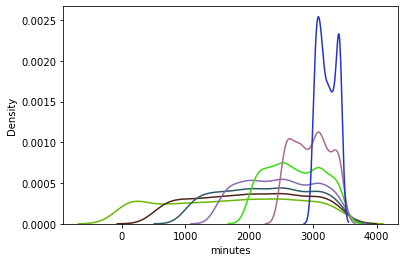

In [10]:
fig, ax = plt.subplots()
for m in np.arange(0, _p['minutes'].max(), 500):
    _mins = _p[_p['minutes']>m]['minutes']
    _bins = _mins.max() // 500
    sns.kdeplot(_mins, ax=ax, color=np.random.rand(3), label=f'>{min} played')

# Total Points vs Minutes

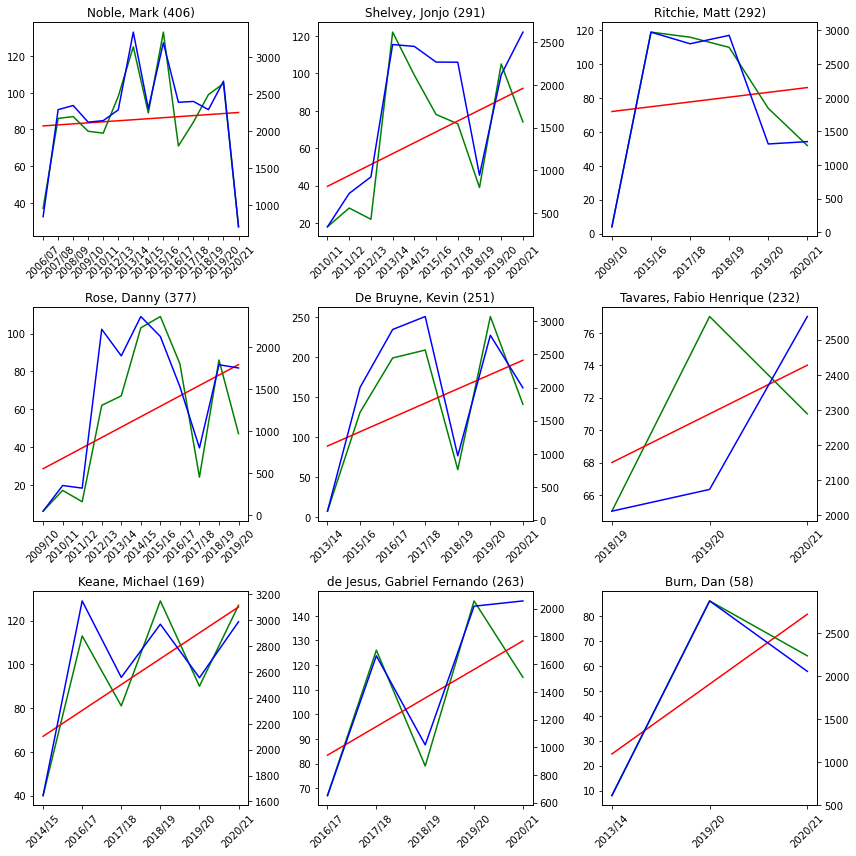

In [11]:
random_players = np.random.choice(_p['id'], 9)
fig, axes = plt.subplots(3, 3, figsize=(12, 12))

i = 0
for rp in random_players:
    player_data = _p[_p['id']==rp]
    idx, idy = divmod(i, 3)
    ax_a = axes[idx, idy]
    ax_b = ax_a.twinx()
    ax_a.plot('season_name', 'total_points', data=player_data, c='g')
    ax_b.plot('season_name', 'minutes', data=player_data, c='b')
    ax_a.set_title(f'{p.loc[rp, "second_name"]}, {p.loc[rp, "first_name"]} ({rp})')
    ax_a.tick_params(axis='x', labelrotation=45)
    i += 1

    # add fit -- can't use this...
    x = np.arange(player_data.shape[0])
    reg = LinearRegression().fit(x.reshape((-1, 1)), player_data['total_points'])
    ax_a.plot(player_data['season_name'], reg.predict(x.reshape((-1, 1))), color='r')
plt.tight_layout()

It's clear we can't apply any fits to such small sample sizes. Will have to take a weighted average?

---

# Filter out first season with low minutes (comparatively)
#### This is to remove any breakthrough year from biasing average results

In [12]:
def iglewicz_hoaglin(s):
    """Iglewicz and Hoaglin modified Z-score.
    s = sample"""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        s = s
        s_median = np.median(s)
        mad = np.median(np.abs(s - s_median))
        return .6745 * (s - s_median) / mad

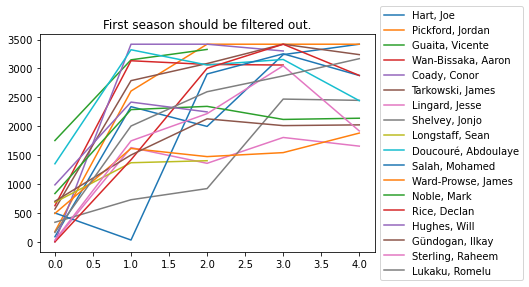

In [13]:
# Check working as expected
fig, ax = plt.subplots()
for i in p.index:
    pdata = _p[_p['id'] == i]
    zscore = iglewicz_hoaglin(pdata['minutes'])
    try:
        if list(zscore)[0] < -3.5:
            ax.plot(np.arange(pdata.shape[0])[:5], pdata['minutes'][:5], label=f'{p.loc[i, "second_name"]}, {p.loc[i, "first_name"]}')
    except IndexError:
        continue
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title('First season should be filtered out.')
plt.show()

# Data out

In [14]:
# Find players where first season should be filtered out
# to avoid biasing averages by breakthrough year.
p_filter_first = []
for i in p.index:
    pdata = _p[_p['id'] == i]
    zscore = iglewicz_hoaglin(pdata['minutes'])
    try:
        if list(zscore)[0] < -3.5:
            p_filter_first.append(i)
    except IndexError:
        continue
print(p_filter_first)


[352, 170, 146, 288, 429, 98, 276, 291, 309, 173, 233, 341, 406, 421, 386, 250, 255, 529]


In [15]:
# Create boolean mask and filter player data DataFrame.
# Also -=1 from all seasons, assume second season as first.
id_minseason = _p.groupby('id').min()['season_name']
_p['keep'] = True
for i, ms in id_minseason.items():
    if i in p_filter_first:
        mask_id = (_p['id']==i)
        mask_minseason = _p['season_name'] == ms
        _p.loc[_p[mask_id].index, 'season_number'] -= 1
        _p.loc[_p[mask_id & mask_minseason].index, 'keep'] = False
_p = _p[_p['keep']]

In [16]:
# Weighted average total points, biased to recent seasons.
sum_seasons = _p.groupby('id')['season_number'].transform('sum')
_p['weighted_points'] = _p['total_points'] * (1 + (_p['season_number'] / sum_seasons))

In [17]:
points = _p[['id', 'total_points', 'weighted_points']].groupby('id').mean()
points.head()

,total_points,weighted_points
id,,
1,117.000,157.388889
2,1.000,2.000000
3,114.875,129.628472
4,157.000,197.900000
5,69.000,78.730159


117.0
157.38888888888889


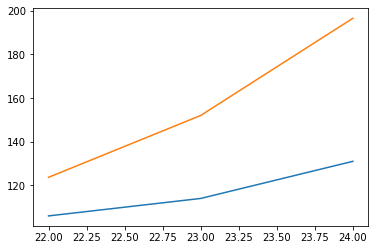

In [18]:
#  Checking...
fig, ax = plt.subplots()
i = 1
_ = _p[(_p['id'] == i)]
ax.plot(_['total_points'])
ax.plot(_['total_points'] * (1 + (_['season_number'] / _['season_number'].sum())))
print(_['total_points'].mean())
print((_['total_points'] * (1 + (_['season_number'] / _['season_number'].sum()))).mean())

In [19]:
p.join(points, how='inner').rename(
    columns={'short_name': 'club'}
    ).to_csv('../data/player_points.csv')